# Getting started

<div class="alert alert-info">

Note: For instrument specific guides, please see the [IRDB](https://irdb.readthedocs.io/en/latest/)

</div>

A basic simulation would look something like this:

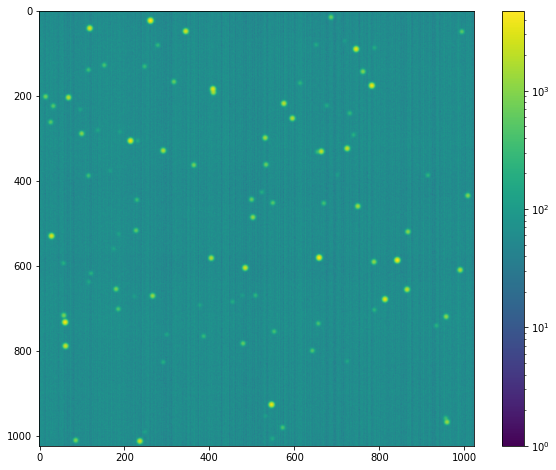

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import scopesim as sim
from scopesim.source import source_templates as st

src = st.star_field(n=100, 
                    mmax=15,      # [mag]
                    mmin=20, 
                    width=200)    # [arcsec]

opt = sim.load_example_optical_train()
opt.cmds["!OBS.dit"] = 60         # [s]
opt.cmds["!OBS.ndit"] = 10

opt.observe(src)
hdulist = opt.readout()[0]

plt.figure(figsize=(10,8))
plt.imshow(hdulist[1].data, norm=LogNorm(), vmin=1)
plt.colorbar()

## Code breakdown

Let's break this down a bit.

There are three major components of any simulation workflow:

1. the target description,
2. the telescope/instrument model, and
3. the observation.

For the target description we are using the ScopeSim internal template functions from `scopesim.source.source_templates`, however many more dedicated science related templates are available in the external python package [ScopeSim-Templates](https://scopesim-templates.readthedocs.io/en/latest/)

Here we create a field of 100 A0V stars with Vega magnitudes between V=15 and V=20 within a box of 200 arcsec:

In [2]:
src = st.star_field(n=100, 
                    mmax=15,      # [mag]
                    mmin=20, 
                    width=200)    # [arcsec]

Next we load the sample optical train object from ScopeSim.

Normally we will want to use an actual instrument. Dedicated documentation for real telescope+instrument systems can be found in the documentation sections of the individual instruments in the [Instrument Reference Database (IRDB) documentation](https://irdb.readthedocs.io/en/latest/)

For real instruments loading the optical system generally follows a different pattern:

    cmd = sim.UserCommands(use_instrument="instrument_name", set_modes=["mode_1", "mode_2"])
    opt = sim.OpticalTrain(cmds)

Once we have loaded the instrument, we can set the observation parameters by accessing the internal commands dictionary:

In [3]:
opt = sim.load_example_optical_train(set_modes=["imaging"])
opt.cmds["!OBS.dit"] = 60         # [s]
opt.cmds["!OBS.ndit"] = 10

Finally we observe the target source and readout the detectors.

What is returned (`hdulist`) is an `astropy.fits.HDUList` object which can be saved to disk in the standard way, or manipulated in a python session.

In [4]:
opt.observe(src)
hdulist = opt.readout()[0]

## Tips and tricks

### Focal plane images

Intermediate frames of the focal plane image without the noise proerties can be accessed by looking inside the optical train object and accessing the first image plane:

In [5]:
noiseless_image = opt.image_planes[0].data

### Turning optical effects on or off

All effects modelled by the optical train can be listed with the `.effects` attribute:

In [6]:
opt.effects

element,name,class,included
str16,str22,str29,bool
basic_atmosphere,atmospheric_radiometry,AtmosphericTERCurve,False
basic_telescope,psf,SeeingPSF,True
basic_telescope,telescope_reflection,TERCurve,True
basic_instrument,static_surfaces,SurfaceList,True
basic_instrument,filter_wheel : [J],FilterWheel,True
basic_instrument,slit_wheel : [narrow],SlitWheel,False
basic_detector,detector_window,DetectorWindow,True
basic_detector,qe_curve,QuantumEfficiencyCurve,True
basic_detector,exposure_action,SummedExposure,True


These can be turned on or off by using their name and the `.include` attribute:

In [7]:
opt["detector_linearity"].include = False

### Listing available modes and filters

The list of observing modes can be found by using the `.modes` attribute of the commands objects:

In [8]:
opt.cmds.modes

imaging: Basic NIR imager
spectroscopy: Basic three-trace long-slit spectrograph


The names of included filters can be found in the filter effect. Use the name of the filter object from the table above to list these:

In [9]:
opt["filter_wheel"].filters

{'BrGamma': FilterCurve: "BrGamma",
 'CH4': FilterCurve: "CH4",
 'J': FilterCurve: "J",
 'H': FilterCurve: "H",
 'Ks': FilterCurve: "Ks",
 'open': FilterCurve: "open"}

### Setting observation sequence

Although this could be different for some instruments, most instruments use the `exptime = ndit * dit` format.
`ndit`and `dit` are generally accessible in the top level `!OBS` dictionary of the command object in the optical train.

In [10]:
opt.cmds["!OBS.dit"] = 60         # [s]
opt.cmds["!OBS.ndit"] = 10

### Listing and changing simulation parameters

The command dictionary inside the optical system contains all the necessary paramters.

In [11]:
opt.cmds

<SystemDict> contents:
SIM: 
  spectral: {'wave_min': 0.7, 'wave_mid': 1.2, 'wave_max': 2.7, 'wave_unit': 'um', 'spectral_bin_width': 0.0001, 'spectral_resolution': 5000, 'minimum_throughput': 1e-06, 'minimum_pixel_flux': 1}
  sub_pixel: {'flag': False, 'fraction': 1}
  random: {'seed': None}
  computing: {'chunk_size': 2048, 'max_segment_size': 16777217, 'oversampling': 1, 'spline_order': 1, 'flux_accuracy': 0.001, 'preload_field_of_views': False, 'bg_cell_width': 60}
  file: {'local_packages_path': './inst_pkgs/', 'server_base_url': 'https://www.univie.ac.at/simcado/InstPkgSvr/', 'use_cached_downloads': False, 'search_path': ['./inst_pkgs/', './'], 'error_on_missing_file': False}
  reports: {'ip_tracking': False, 'verbose': False, 'rst_path': './reports/rst/', 'latex_path': './reports/latex/', 'image_path': './reports/images/', 'image_format': 'png', 'preamble_file': 'None'}
  logging: {'log_to_file': False, 'log_to_console': True, 'file_path': '.scopesim.log', 'file_open_mode': 'w',

The command object is a series of nested dictionaries that can be accessed using the `!-string` format:

    opt.cmds["!<alias>.<param>"]
    opt.cmds["!<alias>.<sub_dict>.<param>"]
    
For example, setting the atmospheric background level is achieved thusly:

In [12]:
opt.cmds["!ATMO.background.filter_name"] = "K"
opt.cmds["!ATMO.background.value"] = 13.6

## More information

For more information on how to use ScopeSim be see:

- [Use Examples](examples/index.rst)
- [Instrument Specific Documentation](https://irdb.readthedocs.io/en/latest/)
- [Effect data formats](effects/formats)
- [Setting up a custom instrument]()


## Contact

- For bugs, please add an [issue to the github repo](https://github.com/AstarVienna/ScopeSim/issues)
- For enquiries on implementing your own instrument package, please drop us a line at astar.astro@univie.ac.at or kieran.leschinski@univie.ac.at